In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/AIFFEL_quest_rs/Exploration/Quest01/
!ls

/content/drive/MyDrive/AIFFEL_quest_rs/Exploration/Quest01
datasets	pytoch_2.ipynb		pytoch_6_ImgClassification.ipynb
models		pytoch_3.ipynb		pytorch_1.ipynb
non_linear.csv	pytoch_4.ipynb		Quest01.ipynb
Pokemon.csv	pytoch_5_DatdAug.ipynb	README.md


In [ ]:
import torch
torch.cuda.empty_cache()

In [3]:
!git pull origin main

From https://github.com/nagujean/AIFFEL_quest_rs
 * branch            main       -> FETCH_HEAD
Already up to date.


In [5]:
!git add .

In [6]:
  !git config --global user.email "nagujean@gmail.com"
  !git config --global user.name "nagujean"

In [7]:
!git commit -m "commit"

Auto packing the repository in background for optimum performance.
See "git help gc" for manual housekeeping.
[main 562b24a] commit
 6 files changed, 1803 insertions(+), 1 deletion(-)
 create mode 100644 Exploration/Quest01/Pokemon.csv
 create mode 100644 Exploration/Quest01/datasets/airplane.jpg
 create mode 100644 Exploration/Quest01/datasets/bus.jpg
 create mode 100644 Exploration/Quest01/datasets/imagenet_classes.txt
 rewrite Exploration/Quest01/pytoch_5_DatdAug.ipynb (84%)
 create mode 100644 Exploration/Quest01/pytoch_6_ImgClassification.ipynb


In [8]:
!git push origin main

Enumerating objects: 16, done.
Counting objects: 100% (16/16), done.
Delta compression using up to 2 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (11/11), 604.51 KiB | 33.58 MiB/s, done.
Total 11 (delta 4), reused 7 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/nagujean/AIFFEL_quest_rs.git
   427bfac..562b24a  main -> main


In [ ]:
!pip install torchinfo

In [ ]:
import torchvision
from torchvision import models
from torchinfo import summary

model = torchvision.models.alexnet(
    weights="AlexNet_Weights.IMAGENET1K_V1"
)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 88.5MB/s]


In [ ]:
summary(model, (1, 3, 224, 224), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [ ]:
with open("./datasets/imagenet_classes.txt") as file:
    classes = file.read().splitlines()

print(f"클래스 개수: {len(classes)}")
print(f"첫번재 클래스 레이블: {classes[0]}")

클래스 개수: 1000
첫번재 클래스 레이블: tench


In [ ]:
#이미지 데이터 전처리

import torch
from PIL import Image
from torchvision import models, transforms

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1").eval().to(device)

tensors =[]
files = ["./datasets/airplane.jpg", "./datasets/bus.jpg"]
for file in files:
  image = Image.open(file)
  tensors.append(transform(image))

tensors = torch.stack(tensors)

print(f"입력텐서의 크기: {tensors.shape}")



입력텐서의 크기: torch.Size([2, 3, 224, 224])


In [ ]:
#아렉스넷 모델 추론

import numpy as np #계산
from torch.nn import functional as F #신경망 모듈


with torch.no_grad(): #기울기 비활성화
    outputs = model(tensors.to(device)) #모델 순방향 추론
    probs = F.softmax(outputs, dim=-1) #모델 출력 로짓을 확률 분포로 변환 . 정규화, 활성화함수
    top_probs, top_idxs = probs.topk(5) #높은 확률 값과 인덱스 추출


top_probs = top_probs.detach().cpu().numpy() # 확률 텐서 변환
top_idxs = top_idxs.detach().cpu().numpy() # 인덱스 텐서 변환
top_classes = np.array(classes)[top_idxs] # 숫자 인덱스를 클래스 이름 문자열 변환

for idx, (cls, prob) in enumerate(zip(top_classes, top_probs)):
    print(f"{files[idx]} 추론 결과")
    for c, p in zip(cls, prob):
        print(f" - {c:<30} : {p * 100:>5.2f}%")


./datasets/airplane.jpg 추론 결과
 - airliner                       : 66.83%
 - warplane                       : 20.12%
 - wing                           :  9.29%
 - space shuttle                  :  2.89%
 - missile                        :  0.38%
./datasets/bus.jpg 추론 결과
 - streetcar                      : 60.25%
 - trolleybus                     : 37.99%
 - minibus                        :  1.54%
 - passenger car                  :  0.17%
 - recreational vehicle           :  0.03%


In [ ]:
#데이터 시각화

In [ ]:
#하이퍼 파라미터 선언 및 이미지 변환

from torch.utils.data import DataLoader # 데이터 배치 단위 처리
from torchvision.datasets import ImageFolder #이미지 폴더 로드
from torchvision import transforms #이미지 데이터 전처리 용 모듈


# 모델 학습에 필요한 하이퍼 파라미터 딕셔너리로 정의
hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256), #사이즈 조정
            transforms.CenterCrop(224), #사이즈를 줄이면서 가운데 집중
            transforms.ToTensor(), #텐서로 변경
            transforms.Normalize( #정규화
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
}

#데이터 셋 불러오기
train_dataset = ImageFolder("./datasets/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("./datasets/pet/test", transform=hyperparams["transform"])

#데이터 로더
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

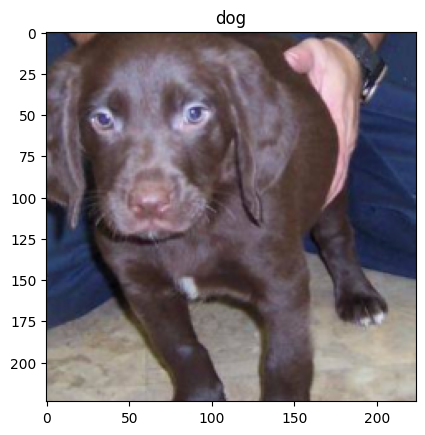

In [ ]:
# 데이터 시각화 전처리한 데이터 확인
import numpy as np
from matplotlib import pyplot as plt


mean=[0.48235, 0.45882, 0.40784]
std=[0.229, 0.224, 0.225]

images, labels = next(iter(train_dataloader))
for image, label in zip(images, labels):
    image = image.numpy().transpose((1, 2, 0))
    image = ((std * image + mean) * 255).astype(np.uint8)

    plt.imshow(image)
    plt.title(train_dataset.classes[int(label)])
    plt.show()
    break

In [ ]:
#모델 불러오기 계층 구조 출력

# torchvision.models 모듈 임포트
from torchvision import models

model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")


In [ ]:
#모델 미세 조정
# torch.nn 모듈 임포트
import torch.nn as nn
# from torchvision import transforms # transform을 위해 필요
# from torch.utils.data import DataLoader # dataloader를 위해 필요

model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

In [ ]:
#모델 및 손실 함수 옵티마이저 지정
# torch 라이브러리 임포트
import torch
# ... (다른 필요한 임포트: nn, optim 등)
import torch.nn as nn
import torch.optim as optim # optimizer를 위해 필요


device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

In [ ]:
#모델 학습 진행 설
for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in train_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :    1, Cost : 0.125
Epoch :    2, Cost : 0.041
Epoch :    3, Cost : 0.032
Epoch :    4, Cost : 0.026
Epoch :    5, Cost : 0.024


In [ ]:
#테스트,평가 루프
import torch
import torch.nn.functional as F

with torch.no_grad(): #기울기 제외
    model.eval() #평가모드

    accuracy = 0.0 #accuracy 초기화
    for images, classes in test_dataloader: #테스트 로더에서 데이터 불러오기
        images = images.to(device) # 장치로 데이터 옮기고
        classes = classes.to(device) #레이블도 옮기고

        outputs = model(images) #모델에 입력해서 예측값 얻고
        probs = F.softmax(outputs, dim=-1)
        # 출력으 확률 분포로 변환 텐서값을 합계가 1인 확률값으로 변환 예측 확률을 나타냄, 마지막 차원에 함수적용
        outputs_classes = torch.argmax(probs, dim=-1)
        #가장 높은 예측 확률을 가진 클래스의 인덱스를 선택

        accuracy += int(torch.eq(classes, outputs_classes).sum())
        #모델의 예측이 실제 레이블과 일치하는 지를 확인 하고 정확하게 예측된 샘플 수를 누적
        #예측과 실제값을 비교하여 같으면 True, 틀리면  False
        #sum은 참은 1 거짓은 0으로 모두 합산한다.
        #결과를 정수형으로 변환후 accuracy에 더해서 업데이트

    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")
    #accuracy 정답수 / 테이터 수 X 배치사이즈 4 * 100퍼센트

acc@1 : 46.53%


In [ ]:
#저장
torch.save(model.state_dict(), "./models/VGG16.pt")
print("Saved the model weights")

In [ ]:
#레즈넷 구현

In [ ]:
#베이직 블록 구현
import torch
from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
#보틀넥 블록

class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
#레즈넷 모델 클래스
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
!pip install torchinfo

In [ ]:
#레즈넷 모델 비교
from torchvision import models
from torchinfo import summary


resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 1000)
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 1000)
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 1000)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 96.0MB/s]


21797672
21797672


In [ ]:
#레즈넷 모델 특징 추출-클래스 활성화 넷 CAM
from torch import nn #
from torchvision import models


model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval() #모델을 불러오고 평가모드로
#이를 통해 Dropout은 비활성화 되고, Batch Normarazation은 미니배치의 평균관 분산을 사용하지 않고, 학습과정에서 누적된 전체
#데이터 셋의 평균과 분산을 고정적으로 사용하여 정규화함.
features = nn.Sequential(*list(model.children())[:-2]) # children 메서드는 sub_modules를 iterator형태로 반환
#-2는 avgpool과 fc 제외 *파이썬 언패킹 연산자 list는 iterator를 list로 변환

In [ ]:
#특징맵과 가중치 추출

from PIL import Image
from torchvision import transforms

#이미지 데이터 전처리
transform = transforms.Compose( # Compose 클래스를 사용하여 객체 생성
    [
        transforms.Resize((224, 224)), # 사이즈 조정
        transforms.ToTensor(), # 텐서 변환
        transforms.Normalize( # Nomaralization
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

image = Image.open("./datasets/airplane.jpg") #PIL.Image 안의 open함수로 데이터 로드
target = transform(image).unsqueeze(0)
#transform 으로 image를 전처리하고 .unsqueeze로 배치 차원을 추가
#transform은 텐서를(c,h,w)형태로 만들고 unsqueeze는 (1,c,h,w)로 만들어서
# 모델이 기대하는 입력 형태를 만들어줌 cnn은 통상 미니배치형태로 입력 받도록 설계되어 있

output = model(target) #모델에 준비된 데이터를 넣는다
class_idx = int(output.argmax())
# 높은 확률 인덱스 찾기 argmax는 가장큰 인덱스를 찾는 파이토치 텐서 메서드
#int 정수타입으로 변환 다른 코드에서 사용가능하도록(어디서?)


weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
#model.fc.weight는 fc 레이어의 학습된 가중치 텐서 이다.
#[class_idx]를 사용하여 가장 높은 확률의 가중치에 해당하는 '행'을 선택
#reshape(-1,1,1)를 통해 1차원 512텐서를 (채널수, 1, 1) 형태의 삼차원 텐서로 변환 나중에 특징맵과 요소별 곱셈의 준
features_output = features(target).squeeze()

print(weights.shape)
print(features_output.shape)

torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


In [ ]:
#클래스 활성화 맵 생성

import torch
from torch.nn import functional as F


cam = features_output * weights
cam = torch.sum(cam, dim=0)
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0),
    size=(image.size[1], image.size[0]),
    mode="bilinear",
).squeeze().detach().numpy()

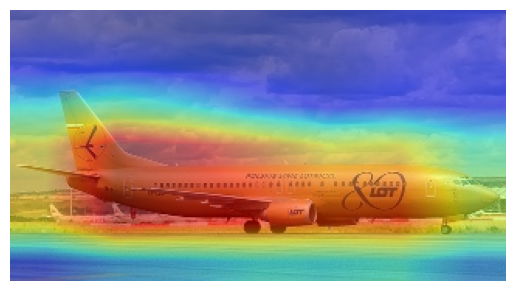

In [ ]:
#클래스 활성화 맵 시각화

import matplotlib.pyplot as plt


plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()